In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

In [3]:
# for SVM
from classifiers.convex.svm import BinarySVM
from classifiers.kernel import Kernel
from classifiers.datasets.dataloader import Example_4x2
from classifiers.datasets import IrisDataset
# for QASVM
from classifiers.quantum.qasvm import QASVM, NormQSVM
from classifiers.quantum.ansatz import Circuit9, sample_circuit
from classifiers.optimizer import tSPSA
from classifiers.callback import CostParamStorage
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import AerSimulator, StatevectorSimulator, Aer, QasmSimulator

In [6]:
ds = IrisDataset(feature_range=(-np.pi, np.pi), true_hot=0)
X, y = ds.sample(2**6, return_X_y=True)

In [10]:
backend = QasmSimulator(device='GPU', shots=2**13)
backend.options

Options(shots=8192, method=None, device='GPU', precision='double', executor=None, max_job_size=None, max_shot_size=None, enable_truncation=True, zero_threshold=1e-10, validation_threshold=None, max_parallel_threads=None, max_parallel_experiments=None, max_parallel_shots=None, max_memory_mb=None, fusion_enable=True, fusion_verbose=False, fusion_max_qubit=5, fusion_threshold=14, accept_distributed_results=None, blocking_qubits=None, blocking_enable=False, memory=None, noise_model=None, seed_simulator=None, statevector_parallel_threshold=14, statevector_sample_measure_opt=10, stabilizer_max_snapshot_probabilities=32, extended_stabilizer_sampling_method='resampled_metropolis', extended_stabilizer_metropolis_mixing_time=5000, extended_stabilizer_approximation_error=0.05, extended_stabilizer_norm_estimation_samples=100, extended_stabilizer_norm_estimation_repetitions=3, extended_stabilizer_parallel_threshold=100, extended_stabilizer_probabilities_snapshot_samples=3000, matrix_product_state_t

In [11]:
_feature_map = Circuit9(X.shape[1], reps=1)
feature_map = _feature_map.copy()
for _ in range(2 - 1):
    feature_map.compose(_feature_map, inplace=True)

var_form = sample_circuit(15)(num_qubits=6, reps=5)
quantum_instance = QuantumInstance(backend=backend, shots=2**13)
qasvm = NormQSVM(
        X, y, lamda=1,
        quantum_instance=quantum_instance,
        var_form=var_form,
        feature_map=feature_map
    )
storage = CostParamStorage()
optimizer = tSPSA(maxiter=2**5, blocking=True, last_avg=16, callback=storage)

In [12]:
qasvm.cost_fn(qasvm.parameters)

Simulation failed and returned the following error message:
ERROR: Failed to load qobj: Simulation device "GPU" is not supported on this system


QiskitError: 'Circuit execution failed: ERROR: Failed to load qobj: Simulation device "GPU" is not supported on this system'

In [13]:
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

In [7]:
from tqdm.notebook import tqdm
for epoch in tqdm(list(range(1, 2**5 + 1))):
    optimizer.step(qasvm.cost_fn, qasvm.parameters)
    if storage.num_accepted() > 2 * 16 and storage.last_cost_avg(2 * 16, ignore_rejected=True) < storage.last_cost_avg(16, ignore_rejected=True):
            break
qasvm.parameters = storage.last_avg(16, ignore_rejected=True)

  0%|          | 0/32 [00:00<?, ?it/s]

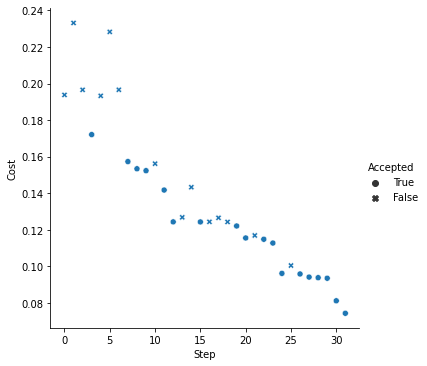

In [8]:
storage.plot()

In [10]:
Xt, yt = ds.data, ds.target
qasvm.accuracy(Xt, yt)

0.94

In [13]:
import pennylane as qml

myqc = qml.from_qiskit(qasvm.second_order_circuit)

ValueError: Converter does not exist. Make sure the required plugin is installed and supports conversion.

In [54]:
from qiskit import QuantumRegister, QuantumCircuit, AncillaRegister, ClassicalRegister
acr = AncillaRegister(2)
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
qc = QuantumCircuit(acr, qr, cr)

qc.h([0, 1, 2, 3])
qc.draw()

┌───┐
    a5_0: ┤ H ├
          ├───┤
    a5_1: ┤ H ├
          ├───┤
q34536_0: ┤ H ├
          ├───┤
q34536_1: ┤ H ├
          └───┘
    c2: 2/═════

In [55]:
from qiskit.quantum_info import Statevector
backend = StatevectorSimulator()
job = backend.run(qc)
state = Statevector(job.result().get_statevector())

In [56]:
qubit = qc.qubits[0]

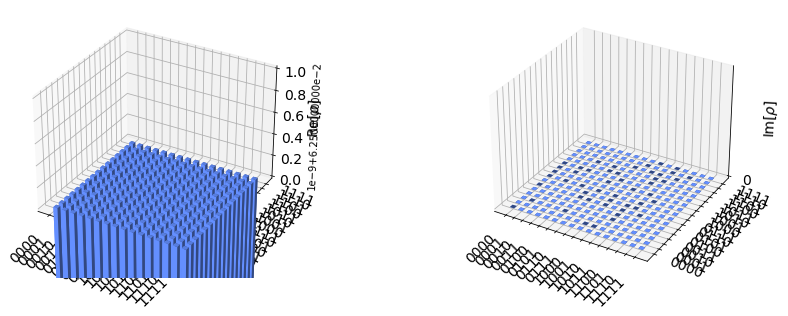

In [57]:
from qiskit.visualization import plot_state_city
plot_state_city(state)

In [58]:
state.probabilities_dict()

{'0000': 0.06250000000000003,
 '0001': 0.06250000000000003,
 '0010': 0.06250000000000003,
 '0011': 0.0625,
 '0100': 0.06250000000000003,
 '0101': 0.0625,
 '0110': 0.0625,
 '0111': 0.06249999999999997,
 '1000': 0.06250000000000003,
 '1001': 0.0625,
 '1010': 0.0625,
 '1011': 0.06249999999999997,
 '1100': 0.0625,
 '1101': 0.06249999999999997,
 '1110': 0.06249999999999997,
 '1111': 0.06249999999999996}